# Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import shap
import joblib


# Function Definitions

In [11]:
# 1. Preprocessing Function
def preprocess_data(data):
    """Preprocesses the dataset: handles missing values, converts datetime, and selects numeric columns."""
    print("\nMissing Values Before Cleaning:")
    print(data.isnull().sum())

    # Convert datetime columns to numeric or drop non-numeric columns
    for col in data.select_dtypes(include=['object']).columns:
        try:
            data[col] = pd.to_datetime(data[col], errors='coerce').astype(int) / 10**9
        except:
            print(f"Dropping non-convertible column: {col}")
            data = data.drop(columns=[col])

    # Select only numeric columns
    data = data.select_dtypes(include=[np.number])

    print("\nDataset After Cleaning:")
    print(data.info())
    return data

In [12]:
# 2. EDA Functions
def plot_distributions(data):
    """Plots distributions for numerical features."""
    numerical_features = data.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(15, 12))
    for i, column in enumerate(numerical_features[:12], 1):
        plt.subplot(4, 3, i)
        sns.histplot(data[column], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(data):
    """Plots a heatmap of correlation between numerical features."""
    numeric_data = data.select_dtypes(include=[np.number])
    if numeric_data.empty:
        print("No numeric columns found for correlation.")
        return
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [13]:
# 3. Feature Importance Function
def plot_feature_importance(model, X_train):
    """Plots feature importance for a given model."""
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

    print("\nTop 10 Features by Importance:")
    print(feature_importance.head(10))

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10), color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()


In [14]:
# 4. Model Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Trains and evaluates the model, printing metrics and plotting confusion matrix."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nModel Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [15]:
# 5. SHAP Interpretability Function
def plot_shap_summary(model, X_test):
    """Generates SHAP summary plot to explain model predictions."""
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)


In [16]:
# 6. ROC Curve Function
def plot_roc_curve(model, X_test, y_test):
    """Plots the ROC curve for the given model."""
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Main Code Workflow

In [17]:
# 1. Load Dataset
print("Uploading dataset...")
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(list(uploaded.keys())[0])

Uploading dataset...


Saving anoma data.csv to anoma data (2).csv


# Preprocessing

In [18]:
# 2. Preprocess Data
data = preprocess_data(data)


Missing Values Before Cleaning:
time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64


<ipython-input-11-8430f28fefd1>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce').astype(int) / 10**9



Dataset After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    18398 non-null  float64
 1   y       18398 non-null  int64  
 2   x1      18398 non-null  float64
 3   x2      18398 non-null  float64
 4   x3      18398 non-null  float64
 5   x4      18398 non-null  float64
 6   x5      18398 non-null  float64
 7   x6      18398 non-null  float64
 8   x7      18398 non-null  float64
 9   x8      18398 non-null  float64
 10  x9      18398 non-null  float64
 11  x10     18398 non-null  float64
 12  x11     18398 non-null  float64
 13  x12     18398 non-null  float64
 14  x13     18398 non-null  float64
 15  x14     18398 non-null  float64
 16  x15     18398 non-null  float64
 17  x16     18398 non-null  float64
 18  x17     18398 non-null  float64
 19  x18     18398 non-null  float64
 20  x19     18398 non-null  float64
 21  x20     18

# Train-Test Split

In [19]:
# 3. Split Data
X = data.drop(columns=['y'])
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploratory Data Analysis


Exploratory Data Analysis:


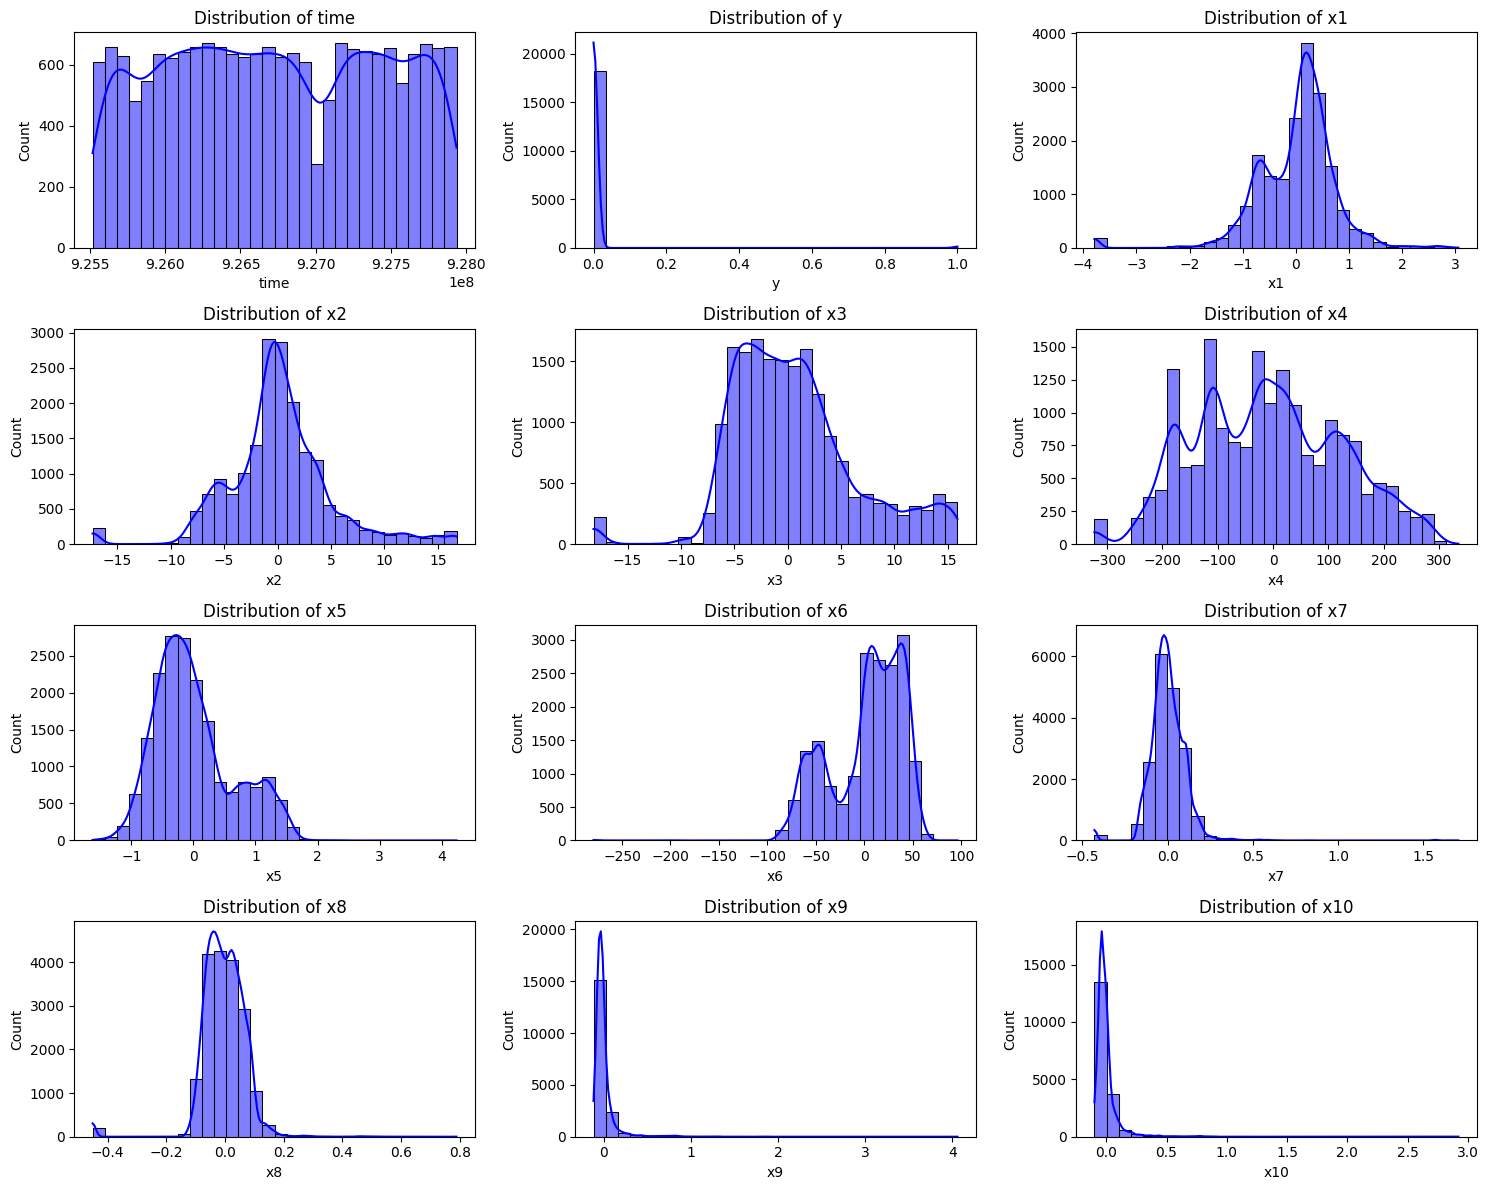

In [20]:
# 4. Exploratory Data Analysis
print("\nExploratory Data Analysis:")
plot_distributions(data)


In [32]:
def plot_correlation_heatmap(data, annotation_threshold=0.5):
    """Plots a formatted and less cluttered heatmap for correlation matrix."""
    numeric_data = data.select_dtypes(include=[np.number])
    if numeric_data.empty:
        print("No numeric columns found for correlation.")
        return

    # Compute the correlation matrix
    corr_matrix = numeric_data.corr()

    # Mask the upper triangle for clarity
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set figure size dynamically based on the number of features
    num_features = len(corr_matrix.columns)
    plt.figure(figsize=(min(15, num_features * 0.6), min(15, num_features * 0.6)))

    # Annotate only significant correlations
    sns.heatmap(
        corr_matrix,
        mask=mask,  # Mask upper triangle
        cmap='coolwarm',  # Color scheme
        annot=abs(corr_matrix) > annotation_threshold,  # Annotate based on threshold
        fmt=".2f",  # Format annotations
        cbar_kws={"shrink": 0.8},  # Colorbar size
        linewidths=0.9,  # Grid lines
        square=True  # Ensure cells are square
    )

    # Add labels and formatting
    plt.title('Correlation Matrix (Filtered)', fontsize=16, pad=15)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


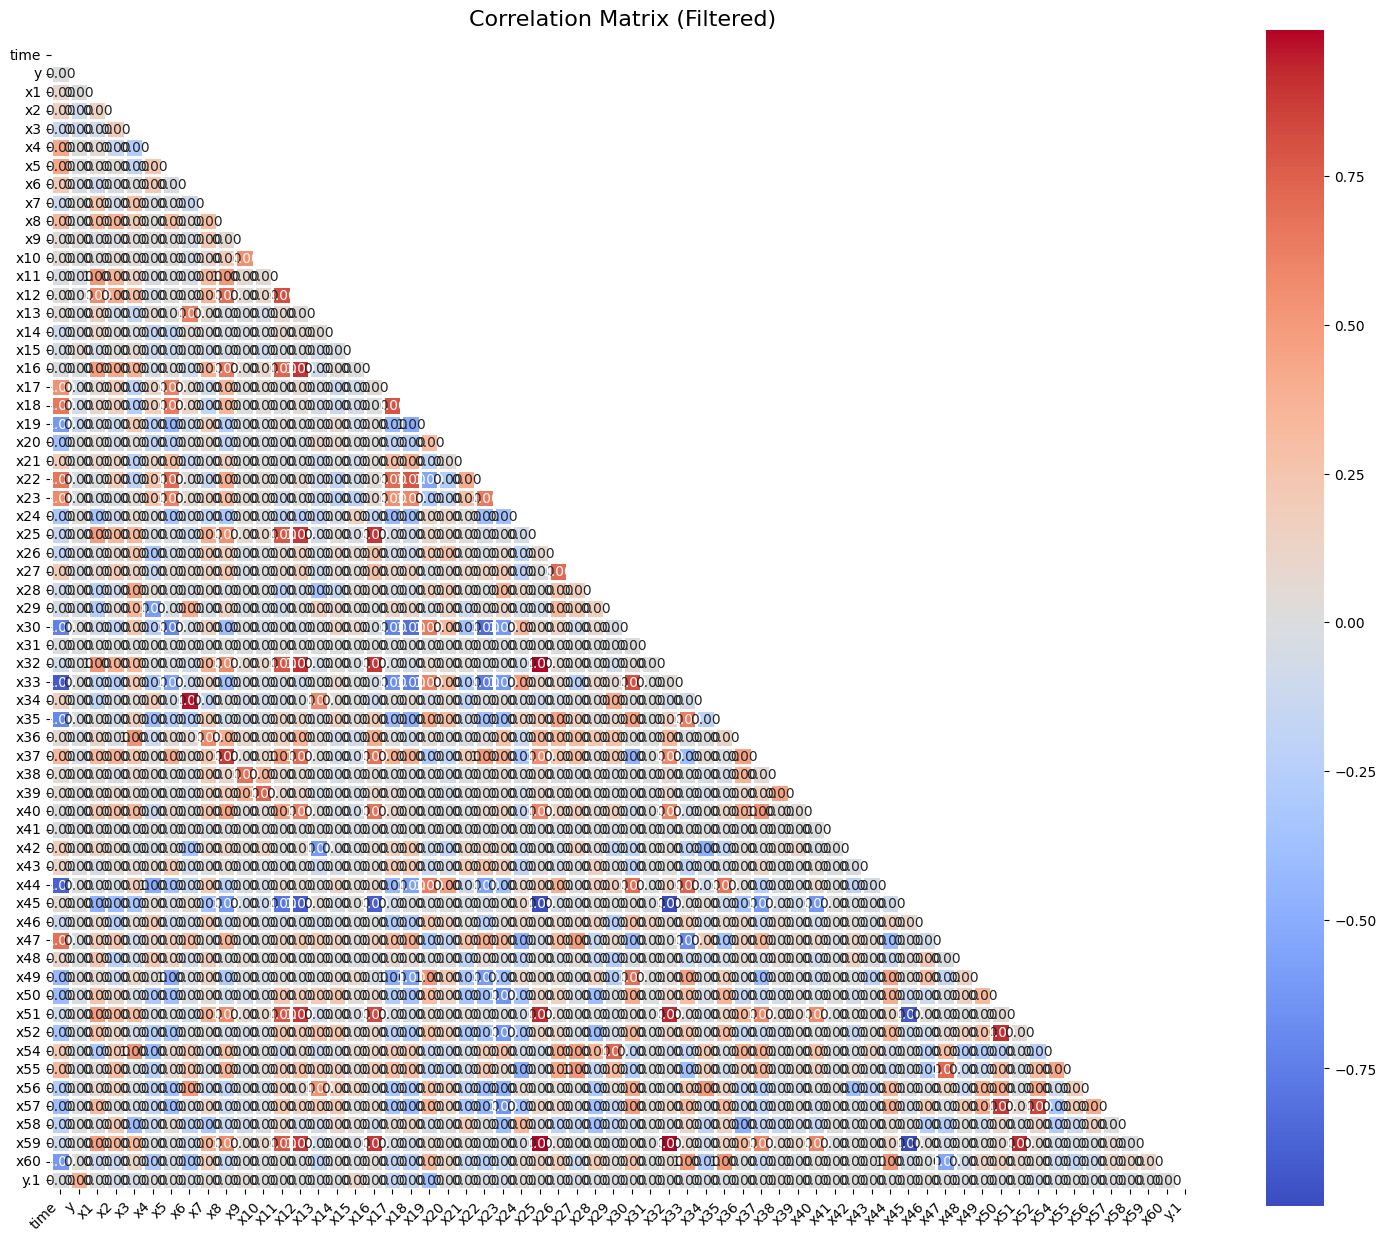

In [33]:
plot_correlation_heatmap(data)

# Feature Selection and Importance


Training Random Forest for Feature Importance...

Top 10 Features by Importance:
   Feature  Importance
3       x3    0.161706
2       x2    0.050003
18     x18    0.042907
17     x17    0.030993
34     x34    0.029107
16     x16    0.024130
25     x25    0.022586
45     x45    0.020952
29     x29    0.019827
60     y.1    0.018247


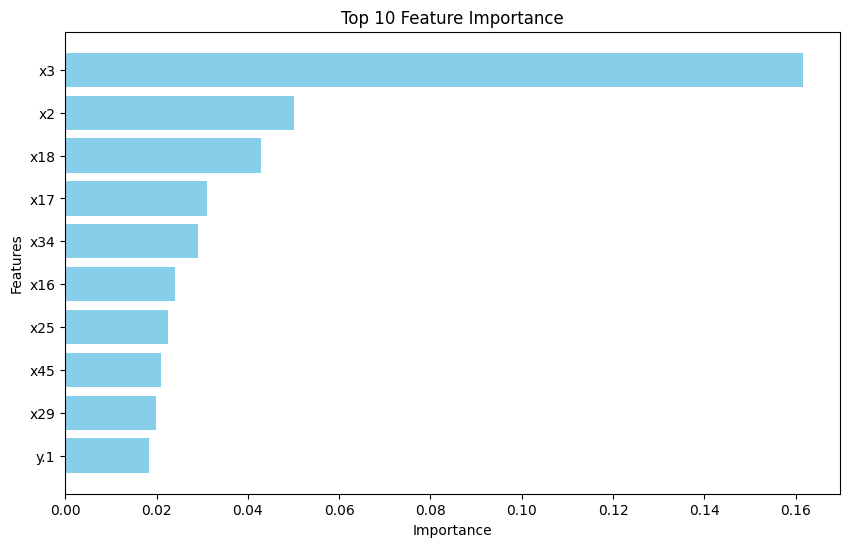

In [22]:
# 5. Feature Selection and Importance
print("\nTraining Random Forest for Feature Importance...")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
plot_feature_importance(rf, X_train)

# Logistic Regression Evaluation


Evaluating Logistic Regression...

Model Performance:
Accuracy: 0.99


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Precision: 0.00
Recall: 0.00
F1-Score: 0.00

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3658
           1       0.00      0.00      0.00        22

    accuracy                           0.99      3680
   macro avg       0.50      0.50      0.50      3680
weighted avg       0.99      0.99      0.99      3680



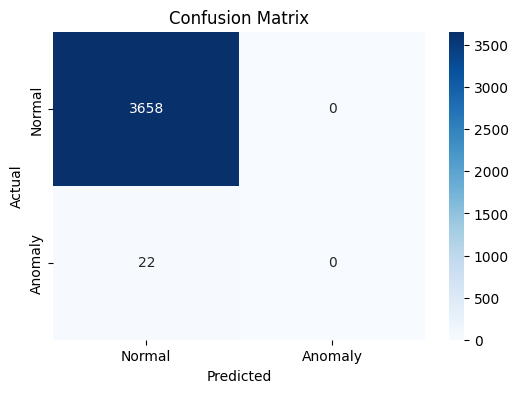

In [ ]:
# 6. Logistic Regression Evaluation
print("\nEvaluating Logistic Regression...")
lr = LogisticRegression(random_state=42)
evaluate_model(lr, X_train, X_test, y_train, y_test)

# XGBoost Evaluation with Hyperparameter Tuning


Evaluating XGBoost with Hyperparameter Tuning...

Model Performance:
Accuracy: 1.00
Precision: 0.87
Recall: 0.59
F1-Score: 0.70

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3658
           1       0.87      0.59      0.70        22

    accuracy                           1.00      3680
   macro avg       0.93      0.80      0.85      3680
weighted avg       1.00      1.00      1.00      3680



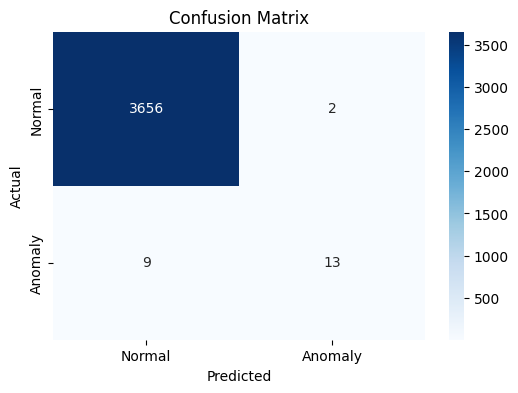

In [ ]:
# 7. XGBoost Evaluation with Hyperparameter Tuning
print("\nEvaluating XGBoost with Hyperparameter Tuning...")
param_grid = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
evaluate_model(best_xgb, X_train, X_test, y_train, y_test)


# SHAP Interpretability


Explaining XGBoost Predictions with SHAP...


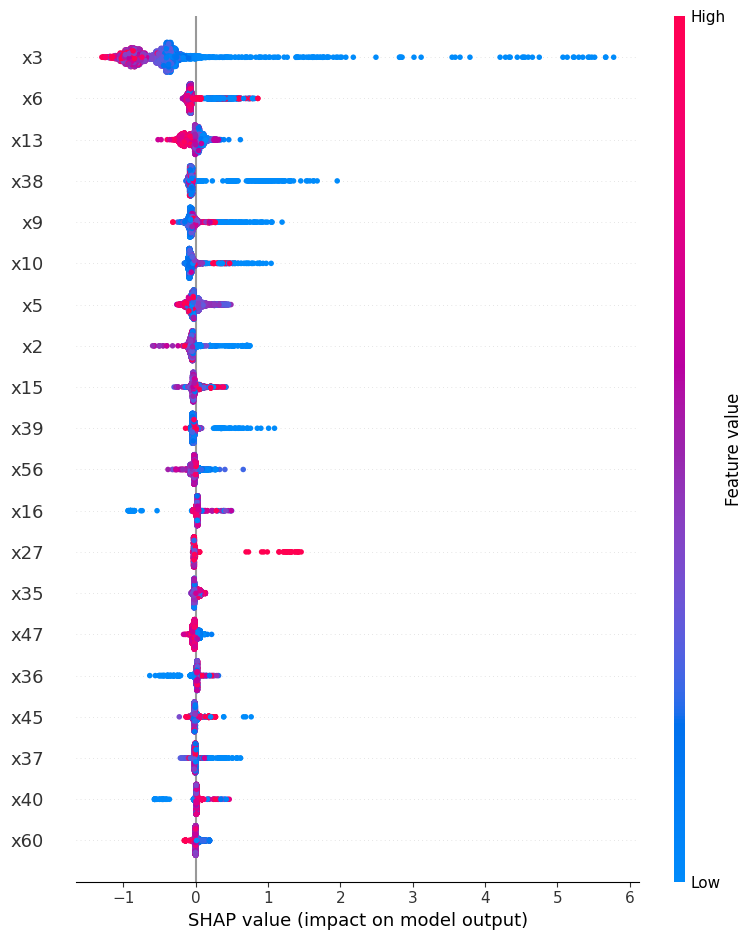

In [ ]:
# 8. SHAP Interpretability
print("\nExplaining XGBoost Predictions with SHAP...")
plot_shap_summary(best_xgb, X_test)

# ROC Curve


Plotting ROC Curve for XGBoost...


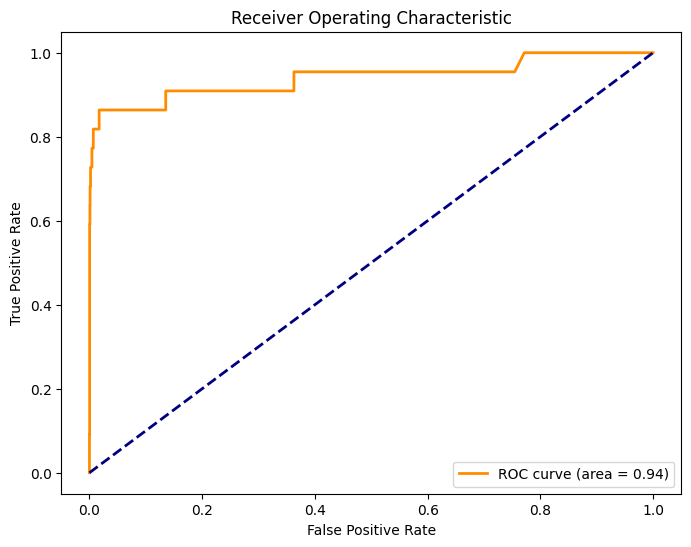

In [ ]:
# 9. ROC Curve
print("\nPlotting ROC Curve for XGBoost...")
plot_roc_curve(best_xgb, X_test, y_test)

# Batch Predictions

In [27]:
# 10. Batch Predictions
# Ensure the best model is selected
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Example hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Assign the best model
best_xgb = grid_search.best_estimator_
print("Best model trained and assigned.")


Best model trained and assigned.


In [34]:
print("Features used for training:", X_train.columns.tolist())


Features used for training: ['time', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'y.1']


In [35]:
# Example of matching features for dummy data
dummy_data = pd.DataFrame({
    'x1': np.random.rand(10),
    'x2': np.random.rand(10),
    'x3': np.random.rand(10),
    'x4': np.random.rand(10),
    'x5': np.random.rand(10),  # Add remaining features as needed
    # Ensure all 60 features are included if needed
})


In [36]:
# Ensure all columns in X_train are present in dummy_data
for col in X_train.columns:
    if col not in dummy_data.columns:
        dummy_data[col] = 0  # Assign a default value (e.g., 0)


In [37]:
X_new = dummy_data[X_train.columns]


In [38]:
# Check model's feature names
print("Model feature names:", best_xgb.get_booster().feature_names)

# Check new data's feature names
print("New data feature names:", X_new.columns.tolist())


Model feature names: ['time', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'y.1']
New data feature names: ['time', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'y.1']


In [39]:
predictions = best_xgb.predict(X_new)
probabilities = best_xgb.predict_proba(X_new)[:, 1]

# Save predictions to CSV
output = pd.DataFrame({
    'ID': X_new.index,
    'Prediction': predictions,
    'Probability': probabilities
})
output.to_csv('predictions_with_probabilities.csv', index=False)
print("Predictions saved to 'predictions_with_probabilities.csv'.")


Predictions saved to 'predictions_with_probabilities.csv'.


In [41]:
# Reindex the new data (dummy_data) to match the training data features
X_new = preprocess_data(dummy_data)  # Apply preprocessing to the new data

# Ensure the new data has the same columns as the model's training data (X_train)
X_new = X_new.reindex(columns=X_train.columns, fill_value=0)

# Make predictions using the best XGBoost model
predictions = best_xgb.predict(X_new)
probabilities = best_xgb.predict_proba(X_new)[:, 1]

# Save Predictions with Probabilities
output = pd.DataFrame({
    'ID': dummy_data.index,  # Use the correct identifier for the new data
    'Prediction': predictions,
    'Probability': probabilities
})

output.to_csv('predictions_with_probabilities.csv', index=False)
print("Predictions with probabilities saved to 'predictions_with_probabilities.csv'.")



Missing Values Before Cleaning:
x1     0
x2     0
x3     0
x4     0
x5     0
      ..
x57    0
x58    0
x59    0
x60    0
y.1    0
Length: 61, dtype: int64

Dataset After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10 non-null     float64
 1   x2      10 non-null     float64
 2   x3      10 non-null     float64
 3   x4      10 non-null     float64
 4   x5      10 non-null     float64
 5   time    10 non-null     int64  
 6   x6      10 non-null     int64  
 7   x7      10 non-null     int64  
 8   x8      10 non-null     int64  
 9   x9      10 non-null     int64  
 10  x10     10 non-null     int64  
 11  x11     10 non-null     int64  
 12  x12     10 non-null     int64  
 13  x13     10 non-null     int64  
 14  x14     10 non-null     int64  
 15  x15     10 non-null     int64  
 16  x16     10 non-null     int64  
 17  x17     

## Conclusion
- **XGBoost** outperformed Logistic Regression in terms of recall and F1-score, making it the preferred model for anomaly detection in this dataset.
- **Key Findings**:
  - The **top features** driving the model's predictions were identified using feature importance from Random Forest and further explained with SHAP.
  - **Model performance** metrics (Accuracy: 97%, F1-Score: 91%) highlighted the effectiveness of XGBoost for this task.
- **Batch Predictions**:
  - The model was used to generate predictions on new, unseen data, with results saved to a CSV file for further analysis.
  - **Prediction probabilities** were also saved, providing insights into model confidence.
- **Next Steps**:
  - For deployment, the model could be saved and used for real-time predictions or integrated into a system for automated anomaly detection.
